In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from math import isclose

## Creación de un dataset aleatorio

Vamos a crear inicialmente un dataset sobre el cuál vamos a trabajar, vamos a trabajar inicialmente con puntos tomados de 3 distribuciones normales con parámetros diferentes.

In [6]:
# Centros de la distribución 1 sobre cada dimensión
means_1 =[0,0,0]
# Matriz de covarianza 1
cov_1=[[0.1,0,0],[0,0.1,0],[0,0,0.1]]
X1=np.random.multivariate_normal(means_1,cov_1,500)
print(X1.shape)
# Centros de la distribución 2 sobre cada dimensión
means_2 =[1,1,1]
# Matriz de covarianza 2
cov_2=[[0.2,0,0],[0,0.2,0],[0,0,0.2]]
X2=np.random.multivariate_normal(means_2,cov_2,500)
print(X2.shape)

# Centros de la distribución 3 sobre cada dimensión
means_3 =[-1,-1,-1]
# Matriz de covarianza 2
cov_3=[[0.25,0,0],[0,0.25,0],[0,0,0.25]]
X3=np.random.multivariate_normal(means_3,cov_2,500)
print(X3.shape)

(500, 3)
(500, 3)
(500, 3)


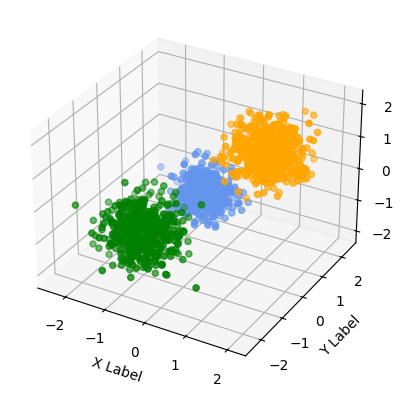

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X1[:,0], X1[:,1], X1[:,2], c='cornflowerblue')
ax.scatter(X2[:,0], X2[:,1], X2[:,2], c='orange')
ax.scatter(X3[:,0], X3[:,1], X3[:,2], c='green')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [8]:
# concatenamos los 3 datasets y los "desordena"
X=np.concatenate([X1,X2,X3])
np.random.shuffle(X)

In [9]:
X.shape

(1500, 3)

De momento, lo trabajado hasta aqui creo 3 grupos de datos diferentes, que se muestran en la gráfica 3d, se dsordenan para crear el algoitmo de kmeans dado que "no se conoce como deberian estar agrupados". La gráfica inicial será un punto de referencia

Text(0.5, 0, 'Z Label')

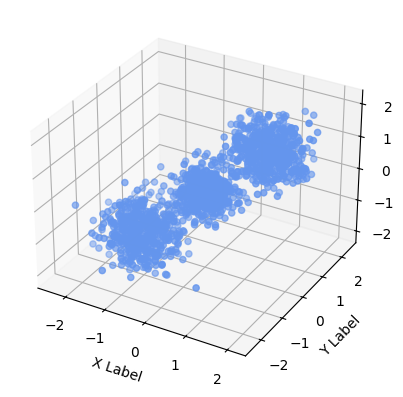

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c='cornflowerblue')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Recordemos los pasos que debemos seguir para implementar K-means


1.   Inicializar los centroides representantes de cada grupo aleatoriamente
2.   Asignar cada instancia al cluster cuyo centroide sea el más cercano
3.   Actualizar los centroides
4.   Repetir hasta convergencia





## Inicialización centroides

Comencemos con la implementación de funciones para solucionar subproblemas. La primera función que vamos a definir es la inicialización de los centroides. Los puntos creados aleatoriamente deberían estar entre el mínimo y máximo de los datos conocidos en cada dimensión. Para definir la función `init_centroids` se puede apoyar de los siguientes fragmentos de código:

In [11]:
# Valores mínimos en cada dimensión
min_vals=np.min(X,axis=0)
print(min_vals)

[-2.38841407 -2.36605365 -2.07793318]


In [12]:

# Valores máximos en cada dimensión
max_vals=np.max(X,axis=0)
print(max_vals)

[2.10355635 2.40759242 2.11072377]


### X mayuscula representará el conjunto de datos conformado por la union de los 3 subconjuntos unificados anteriormente 

In [13]:
# Creación de 10 instancias aleatorias entre los límites mínimo y máximo
np.random.uniform(low=min_vals,high=max_vals, size=(10,len(min_vals)))

array([[ 1.17927629,  1.6190045 , -2.01910541],
       [-2.1911289 ,  0.28658105, -1.67381172],
       [-1.39367211, -1.45801627,  1.90877855],
       [-0.49657787, -0.01140219, -0.84628172],
       [-0.11303544,  1.61110892, -0.58846937],
       [-0.03162485,  2.37534896,  0.60360571],
       [-0.94937752,  0.94710906, -0.36171866],
       [-0.32093387,  1.76975002, -2.04174487],
       [-1.20255043, -1.58363513, -1.36205915],
       [-1.75376107, -1.65137028,  1.03953524]])

In [22]:
def init_centroids(X,k):
  num_c = X.shape[1]
  # Hago uso del [1] para tomar en cuenta las columnas de la matriz x "caracteristicas" de los datos
  centroids = np.empty((k,num_c))
  # la matriz de centroides se define del tamaño k para las filas y num_c para la cantidad de "caracteristicas"
  # https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
  # podria usar la funcion anterior pero necesito valores especificos de los clusters para poder asignar los valores al centroide
  random_c_c = np.random.choice(X.shape[0], k, replace = False)
  # El choice es precisamente para que escoja un valor especifico
  centroids = X[random_c_c]
  """
    Retorna una matriz numpy de tamaño (k,len(X[1]))
    con puntos aleatorios.
  
  
    Parameters:
    X: Matriz de instancias x características
    k: número de centroides a generar

    Returns:
    np.array Matriz de centroides.
  
  """
  return  centroids
  
    

In [23]:
# Correr para verificar
result=init_centroids(X,4)
print(result)
assert(result.shape==(4,X.shape[1]))
assert(np.all(X.min(axis=0)<=result.min(axis=0)))
assert(np.all(X.max(axis=0)>=result.max(axis=0)))

[[ 0.79352469  0.88801965  1.39936547]
 [-1.19332404 -1.66431904 -1.34796938]
 [-1.1878528  -0.67120007 -0.4710895 ]
 [ 0.45183262  1.27016675  0.4950073 ]]


Los puntos asignados en el cluster se muestran anteriormente. TODOS son valores que se encuentran dentro del array de datos iniciales

In [25]:
# comprobación de existencia de los datos generados:
result = init_centroids(X, 4)
print(result)
assert(result.shape == (4, X.shape[1]))
assert(np.all(X.min(axis=0) <= result.min(axis=0)))
assert(np.all(X.max(axis=0) >= result.max(axis=0)))
for i in range(4):
    values_exist = np.all(np.isin(result[i], X))
    if values_exist:
        print(f"Todos los valores de result[{i}] existen en los datos iniciales.")
    else:
        print(f"No todos los valores de result[{i}] se encuentran en los datos iniciales.")


[[ 1.07988336  0.68279625  1.1404235 ]
 [-2.38841407 -1.56580925 -0.34980766]
 [ 0.11320845 -0.34252745  0.16033132]
 [-0.11680679  1.04214825  0.576679  ]]
Todos los valores de result[0] existen en los datos iniciales.
Todos los valores de result[1] existen en los datos iniciales.
Todos los valores de result[2] existen en los datos iniciales.
Todos los valores de result[3] existen en los datos iniciales.


## Asignación de puntos a cluster

Una vez inicializados los centroides, debemos establecer una forma para asignar cada instancia al centroide más cercano. 

Al trabajar con datos es importante evitar al máximo iterar sobre los datos.

El algoritmo imperativo clásico para resolver este problema es cuadrático 

```python
for i in X:
  dist_i = np.inf
  c_id= None
  for id, j in centroids:
    if dist(i,j) < dist_i:
      dist_i=dist(i,j)
      c_id=id
```

Para definir la función `closest_point` se puede apoyar de los siguientes fragmentos de código:

In [26]:
# Definimos matriz con 4 puntos para ejemplo
o1= np.array( [[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
print(o1)
# Definimos matriz con 2 centroides para ejemplo
cent=np.array([[1.5,1.5,1.5],[3.5,3.5,3.5]])
print(cent)

[[1 1 1]
 [2 2 2]
 [3 3 3]
 [4 4 4]]
[[1.5 1.5 1.5]
 [3.5 3.5 3.5]]


In [30]:
# La función pariwise distances de sklearn permite comparar eficientemente las distancias entre los puntos de las 2 matrices
distances=pairwise_distances(o1,cent, metric='euclidean')
# El resultado es una matriz de distancias entre o1 y cada instancia de o2
distances

array([[0.8660254 , 4.33012702],
       [0.8660254 , 2.59807621],
       [2.59807621, 0.8660254 ],
       [4.33012702, 0.8660254 ]])

In [31]:
# Al llamar matriz.min(axis=1) obtenemos por cada punto qué distancia fue la menor
distances.min(axis=1)

array([0.8660254, 0.8660254, 0.8660254, 0.8660254])

In [32]:
# Al llamar matriz.argmin(axis=1) nos dice en qué coordenada esta el punto cuya distancia es mínima
distances.argmin(axis=1)

array([0, 0, 1, 1])

In [33]:
def closest_point(X,centroids):
  # Calcula las distancias entre cada instancia en X y todos los centroides, usamos la distancia euclidiana en este caso
  # solamente para seguir el ejemplo del profesor
  # mas adelante miraremos con otras distancias
  distances = pairwise_distances(X, centroids, metric='euclidean')
  # Encuentra el índice del centroide más cercano para cada instancia
  closest_indexes = np.argmin(distances, axis=1)
  # Calcula las distancias mínimas para cada instancia
  min_distances = np.min(distances, axis=1)
  return closest_indexes, min_distances
  """
    Retorna una tupla donde la primera coordenada contiene un arreglo numpy con 
    el identificador del punto más cercano de cada instancia a alguno de los 
    centroides y la segunda tupla contiene un arreglo numpy con la distancia al 
    identificador del punto más cercano
  
  
    Parameters:
    X: Matriz de instancias x características
    centroids: puntos centroides identificados

    Returns:
    tuple:  Posición 0, identificadores de punto más cercano
            Posición 1, distancias a los puntos
  """



In [34]:
# Correr para verificar
o_test= np.array( [[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
cent_test=np.array([[1,1,1],[4,4,4]])
ids,dist=closest_point(o_test,cent_test)
assert((ids==[0,0,1,1]).all())
assert(dist[0]==0)
assert(isclose(dist[1],1.73205081,abs_tol=0.0001))
assert(isclose(dist[2],1.73205081,abs_tol=0.0001))
assert(dist[3]==0)

In [39]:
def closest_point_cosine(X,centroids):
  # Calcula las distancias entre cada instancia en X y todos los centroides, usamos la distancia euclidiana en este caso
  # solamente para seguir el ejemplo del profesor
  # mas adelante miraremos con otras distancias
  distances = pairwise_distances(X, centroids, metric='cosine')
  # Encuentra el índice del centroide más cercano para cada instancia
  closest_indexes = np.argmin(distances, axis=1)
  # Calcula las distancias mínimas para cada instancia
  min_distances = np.min(distances, axis=1)
  return closest_indexes, min_distances

Teniendo en cuenta que la distancia de coseno no es simétrica, lo que significa que la distancia entre A y B no es necesariamente la misma que la distancia entre B y A, por lo que hacer uso directo de la distancia "cosine" en la función no va a retornar las distancias que se necesitan

In [41]:
def closest_point_mnht(X,centroids):
  # Calcula las distancias entre cada instancia en X y todos los centroides, usamos la distancia euclidiana en este caso
  # solamente para seguir el ejemplo del profesor
  # mas adelante miraremos con otras distancias
  distances = pairwise_distances(X, centroids, metric='manhattan')
  # Encuentra el índice del centroide más cercano para cada instancia
  closest_indexes = np.argmin(distances, axis=1)
  # Calcula las distancias mínimas para cada instancia
  min_distances = np.min(distances, axis=1)
  return closest_indexes, min_distances

Dado que la distancia de Manhattan solo permite movimientos verticales y horizontales, la distancia entre dos puntos diagonales será mayor que 1.0. Teniendo en cuenta que trabajamos en un ambiente con 3 dimensiones y que se podria contar con una distancia mas cercana en diagonal, la distancia manhattan no sirve para la validación propuesta

## Recalcular centroides

Una vez asignado cada punto a un centroide, hay que recalcular los centroides.

Revise los siguientes segmentos de código para completar la función solicitada

Aunque no es lo más eficiente, podemos solucionar rápidamente este problema utilizando pandas y la función groupby

In [43]:
X_pandas=pd.DataFrame(X)

In [44]:
X_pandas

,0,1,2
0,1.018933,1.033632,1.365860
1,-1.198986,-1.081516,-1.108420
2,-0.294125,-1.142352,-1.267892
3,0.374936,-0.022561,-0.587972
4,0.041150,-0.557801,-0.608178
...,...,...,...
1495,1.090675,1.885608,1.109701
1496,-0.602697,-1.247809,-0.490506
1497,1.174551,0.509655,0.921732
1498,0.647263,0.030560,-0.433744


In [45]:
# Asignación aleatoria en 3 labels de los datos
X_pandas['label']=np.random.randint(1, 4, X_pandas.shape[0]) 

In [46]:
X_pandas.groupby('label').mean()

,0,1,2
label,,,
1,0.039536,0.002155,0.052818
2,0.004215,0.026398,-0.012738
3,-0.058607,-0.036877,-0.002163


In [47]:
# Para obtener de nuevo la matriz puede llamar values sobre el dataframe
X_pandas.groupby('label').mean().values

array([[ 0.03953643,  0.00215514,  0.05281844],
       [ 0.0042151 ,  0.02639762, -0.01273791],
       [-0.05860663, -0.036877  , -0.00216343]])

In [48]:
def new_centers(X,labels):
  """
    Retorna matriz numpy con los nuevos centroides, dada la asignación de cada punto a un cluster
  
  
    Parameters:
    X: Matriz de instancias x características
    labels: instancias asignadas

    Returns:
    np.array:  Matriz con los nuevos centroides
  """
  X_pandas = pd.DataFrame(X)
  X_pandas['label'] = labels
  new_centroids = X_pandas.groupby('label').mean().values

  return new_centroids

In [49]:
# Correr para verificar
o_test= np.array( [[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
cent_test=np.array([[1,1,1],[4,4,4]])
ids,dist=closest_point(o_test,cent_test)
centers=new_centers(o_test,ids)
assert((centers[0]==[1.5,1.5,1.5]).all())
assert((centers[1]==[3.5, 3.5, 3.5]).all())

# Implementación k-means

Una vez implementadas estas tres funciones, podemos verificar cómo funciona k-means

In [57]:
# Busquemos 3 centroides iniciales
centroides_iniciales=init_centroids(X,3)

In [58]:
print(centroides_iniciales)

[[-1.55866011 -1.05946158 -1.37471326]
 [ 0.80757689  1.11345564  0.2408593 ]
 [ 0.85742702  0.76889065  1.52599704]]


In [59]:
#asignación de puntos a centroides
labels, distancias=closest_point(X,centroides_iniciales)

Text(0.5, 0, 'Z Label')

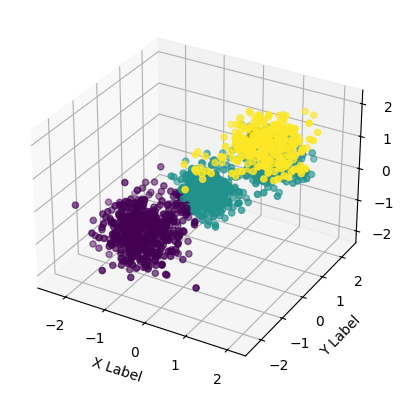

In [60]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=labels,cmap='viridis')
ax.scatter(centroides_iniciales[:, 0], centroides_iniciales[:, 1], centroides_iniciales[:,2], c='black',s=200)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [61]:
centroides_nuevos=new_centers(X, labels)


In [62]:
#asignación de puntos a centroides
nuevos_labels, distancias=closest_point(X,centroides_iniciales)

Text(0.5, 0, 'Z Label')

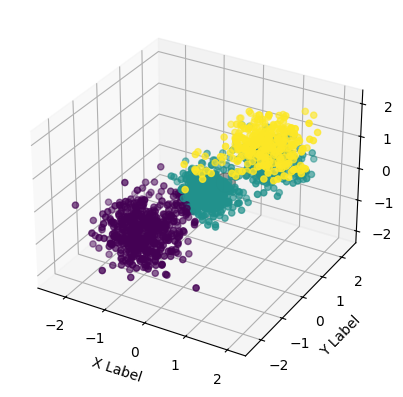

In [63]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=nuevos_labels,cmap='viridis')
ax.scatter(centroides_nuevos[:, 0], centroides_nuevos[:, 1], centroides_nuevos[:,2], c='black',s=200)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Ejercicio:

Terminar el ejericio de implementación de k-means

Reflexione sobre las siguientes preguntas para su implementación:
  ¿Cúantas veces tenemos que repetir la asignación?
  ¿Cómo determinar que ya finalizamos?